In [9]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# Generate Synthetic Video
def generate_synthetic_video(video_length=30, frame_rate=2):
    width, height = 1000, 480
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('synthetic_bicycle.mp4', fourcc, frame_rate, (width, height))

    for i in range(video_length * frame_rate):
        frame = np.zeros((height, width, 3), dtype=np.uint8)
        
        # Draw a rectangle to represent the bicycle (moving from left to right)
        bicycle_pos = int(i * (width // (video_length * frame_rate)) % width)
        cv2.rectangle(frame, (bicycle_pos, height // 2 - 20), (bicycle_pos + 40, height // 2 + 20), (255, 0, 0), -1)
        
        # Write the frame to the video
        out.write(frame)

    out.release()
    print("Synthetic video generated.")

# Generate the synthetic video
generate_synthetic_video()


Synthetic video generated.


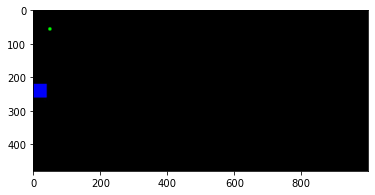

In [14]:
# Particle Filter Class
class ParticleFilter:
    def __init__(self, num_particles=100):
        self.num_particles = num_particles
        self.particles = np.random.rand(num_particles, 2) * 100  # Initialize particles
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, movement):
        self.particles += movement + np.random.normal(0, 10, self.particles.shape)  # Add noise to particles

    def update(self, measurement):
        for i, particle in enumerate(self.particles):
            self.weights[i] = self.calculate_likelihood(particle, measurement)
        
        # Prevent division by zero
        weight_sum = np.sum(self.weights)
        if weight_sum > 0:
            self.weights /= weight_sum  # Normalize weights
        else:
            self.weights.fill(1.0 / self.num_particles)

    def resample(self):
        indices = np.random.choice(range(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def calculate_likelihood(self, particle, measurement):
        distance = np.linalg.norm(particle - measurement)
        return np.exp(-distance ** 2) if not np.isnan(distance) else 0

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)


# 4. Detection and Visualization
def detect_bicycle_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    pf = ParticleFilter()
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        current_frame = frame.copy()
        # Simulated measurement for bicycle position (for demonstration)
        measurement = np.array([current_frame.shape[1] / 2, current_frame.shape[0] / 2])  # assuming center

        pf.predict(movement=np.array([5, 0]))  # Dummy movement
        pf.update(measurement)
        pf.resample()
        estimated_pos = pf.estimate()

        # Draw the estimate on the frame
        cv2.circle(current_frame, (int(estimated_pos[0]), int(estimated_pos[1])), 5, (0, 255, 0), -1)
        frames.append(current_frame)

    cap.release()
    return frames

# Call detection function and generate results
video_frames = detect_bicycle_in_video('synthetic_bicycle.mp4')

# Display one of the frames with predicted position
plt.imshow(cv2.cvtColor(video_frames[0], cv2.COLOR_BGR2RGB))


In [19]:
# Particle Filter Class with particle density visualization
import cv2
import numpy as np

# Particle Filter Class with particle density visualization
class ParticleFilter:
    def __init__(self, num_particles=100, frame_size=(640, 480)):
        self.num_particles = num_particles
        self.frame_width, self.frame_height = frame_size
        self.particles = np.random.rand(num_particles, 2) * [self.frame_width, self.frame_height]  # Initialize particles
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, movement):
        self.particles += movement + np.random.normal(0, 10, self.particles.shape)  # Add noise to particles

    def update(self, measurement):
        for i, particle in enumerate(self.particles):
            self.weights[i] = self.calculate_likelihood(particle, measurement)
        
        # Prevent division by zero
        weight_sum = np.sum(self.weights)
        if weight_sum > 0:
            self.weights /= weight_sum  # Normalize weights
        else:
            self.weights.fill(1.0 / self.num_particles)

    def resample(self):
        indices = np.random.choice(range(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def calculate_likelihood(self, particle, measurement):
        distance = np.linalg.norm(particle - measurement)
        return np.exp(-distance ** 2 / 50)  # Adjust scaling factor to match the object size

    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=0)

# Visualization of particle density on the video
def detect_bicycle_in_video_with_density(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    
    # Ensure video file is opened
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Check for valid video parameters
    print(f"Video Parameters: width={frame_width}, height={frame_height}, fps={fps}")

    # Create a VideoWriter object to save the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Check if VideoWriter is opened correctly
    if not out.isOpened():
        print("Error: Could not open the video writer.")
        return

    pf = ParticleFilter(num_particles=300, frame_size=(frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading frame.")
            break

        current_frame = frame.copy()

        # Simulated measurement for bicycle position (for demonstration)
        measurement = np.array([current_frame.shape[1] / 2, current_frame.shape[0] / 2])  # assuming center

        # Predict particle movement (dummy movement for now)
        pf.predict(movement=np.array([5, 0]))  # Move particles to the right
        pf.update(measurement)
        pf.resample()
        estimated_pos = pf.estimate()

        # Draw particles as small circles
        for particle in pf.particles:
            cv2.circle(current_frame, (int(particle[0]), int(particle[1])), 2, (255, 255, 0), -1)

        # Draw the estimated position as a larger green circle
        cv2.circle(current_frame, (int(estimated_pos[0]), int(estimated_pos[1])), 8, (0, 255, 0), -1)

        # Add density effect by darkening regions with many particles
        density_map = np.zeros((frame_height, frame_width), dtype=np.float32)
        for particle in pf.particles:
            x, y = int(particle[0]), int(particle[1])
            if 0 <= x < frame_width and 0 <= y < frame_height:
                density_map[y, x] += 1  # Increase density where particles exist

        # Normalize and convert density map to color heatmap
        density_map = cv2.GaussianBlur(density_map, (25, 25), 0)
        density_map = np.clip(density_map / density_map.max(), 0, 1) * 255
        density_map = density_map.astype(np.uint8)
        density_colormap = cv2.applyColorMap(density_map, cv2.COLORMAP_JET)

        # Overlay the density map on the original frame
        overlay = cv2.addWeighted(current_frame, 0.7, density_colormap, 0.3, 0)

        # Write the frame with particle density visualization to the output video
        out.write(overlay)

    cap.release()
    out.release()
    print(f"Output video saved as {output_path}")

# Generate the video with particle density overlay
detect_bicycle_in_video_with_density('synthetic_bicycle.mp4', 'particle_density_output_fixed.mp4')



Video Parameters: width=1000, height=480, fps=2
End of video or error reading frame.
Output video saved as particle_density_output_fixed.mp4
